In [1]:
# Fix PIL/Pillow compatibility issue first
!pip uninstall -y pillow
!pip install pillow==10.0.0

# Install development version of diffusers for Flux Control
!pip uninstall -y diffusers
!pip install git+https://github.com/huggingface/diffusers.git

# Install other required packages
!pip install -q transformers accelerate peft datasets
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q wandb huggingface_hub xformers
!pip install -q bitsandbytes  # For memory optimization
!pip install -q sentencepiece  # Required for T5 tokenizer
!pip install -q protobuf  # Additional dependency for tokenizers
!pip install -q matplotlib

# Verify installation
import diffusers
print(f"Diffusers version: {diffusers.__version__}")

import PIL
print(f"PIL version: {PIL.__version__}")

# Test ExifTags access
try:
    from PIL import ExifTags
    print("✅ ExifTags import successful")
except ImportError:
    print("❌ ExifTags import failed")

# Test sentencepiece
try:
    import sentencepiece
    print("✅ SentencePiece installed successfully")
except ImportError:
    print("❌ SentencePiece import failed")

# Test transformers tokenizer
try:
    from transformers import T5TokenizerFast
    print("✅ T5 tokenizer imports successful")
except ImportError as e:
    print(f"❌ T5 tokenizer import failed: {e}")

Found existing installation: Pillow 10.0.0
Uninstalling Pillow-10.0.0:
  Successfully uninstalled Pillow-10.0.0
  Using cached Pillow-10.0.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (9.5 kB)
Using cached Pillow-10.0.0-cp310-cp310-manylinux_2_28_x86_64.whl (3.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.16.0+cu118 requires torch==2.1.0, but you have torch 2.7.0 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Found existing installation: diffusers 0.34.0.dev0
Uninstalling diffusers-0.34.0.dev0:
  Successfully uninstalled diffusers-0.34.0.dev0
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-dme420yw
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-

In [2]:
import os
import torch
from huggingface_hub import login, snapshot_download
from datasets import load_dataset


# Check GPU availability
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name()}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

GPU available: True
GPU name: NVIDIA A40
GPU memory: 44.4 GB


In [ ]:
from huggingface_hub import login

import os

login(token = os.getenv("HF_TOKEN"))

In [3]:
# For image-to-image editing with LoRA, we need the Flux Control LoRA training script
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/flux-control/train_control_lora_flux.py

# Check if file downloaded successfully
import os
if os.path.exists("train_control_lora_flux.py"):
    print("✅ Flux Control LoRA training script downloaded successfully")
else:
    print("❌ Failed to download training script")

--2025-06-05 07:27:52--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/flux-control/train_control_lora_flux.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59750 (58K) [text/plain]
Saving to: ‘train_control_lora_flux.py.11’

train_control_lora_ 100%[===================>]  58.35K  --.-KB/s    in 0.008s  

2025-06-05 07:27:52 (7.51 MB/s) - ‘train_control_lora_flux.py.11’ saved [59750/59750]

✅ Flux Control LoRA training script downloaded successfully


In [4]:
# Download both Flux Control LoRA and Dreambooth LoRA scripts
print("Downloading Flux Control LoRA training script...")
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/flux-control/train_control_lora_flux.py

print("Downloading Dreambooth LoRA training script (fallback)...")
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_flux.py

# Check if files downloaded successfully
import os
flux_control_exists = os.path.exists("train_control_lora_flux.py")
dreambooth_exists = os.path.exists("train_dreambooth_lora_flux.py")

print(f"✅ Flux Control LoRA script: {'Downloaded' if flux_control_exists else 'Failed'}")
print(f"✅ Dreambooth LoRA script: {'Downloaded' if dreambooth_exists else 'Failed'}")

# Check diffusers version for compatibility
import diffusers
version = diffusers.__version__
print(f"Diffusers version: {version}")

if "dev" in version or version >= "0.34.0":
    print("✅ Version compatible with Flux Control training")
else:
    print("⚠️  Version may not be compatible, will use Dreambooth LoRA as fallback")

--2025-06-05 07:27:52--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/flux-control/train_control_lora_flux.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59750 (58K) [text/plain]
Saving to: ‘train_control_lora_flux.py.12’

train_control_lora_ 100%[===================>]  58.35K  --.-KB/s    in 0.006s  

2025-06-05 07:27:52 (9.45 MB/s) - ‘train_control_lora_flux.py.12’ saved [59750/59750]

--2025-06-05 07:27:52--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_flux.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443..

In [3]:
from datasets import load_dataset
import os
from PIL import Image

# Use streaming mode
print("Loading dataset in streaming mode...")
dataset_stream = load_dataset(
    "sayakpaul/OmniEdit-mini", 
    split="train",
    streaming=True
)

# Create training directories for image-to-image setup
os.makedirs("training_data/images", exist_ok=True)
os.makedirs("training_data/conditioning_images", exist_ok=True)

# Process first 300 samples from the stream (adjust as needed)
num_samples = 1500
samples_processed = 0

print(f"Processing first {num_samples} samples...")

for i, sample in enumerate(dataset_stream):
    if samples_processed >= num_samples:
        break
    
    try:
        # Use correct column names from the dataset
        input_image = sample['src_img']  # Source image
        edited_image = sample['edited_img']  # Edited image
        instruction_list = sample['edited_prompt_list']  # List of prompts
        
        # Use the first instruction from the list
        instruction = instruction_list[0] if instruction_list else "edit this image"
        
        # Save the input image (conditioning image for editing)
        input_image.save(f"training_data/conditioning_images/image_{samples_processed:04d}.jpg")
        
        # Save the target edited image  
        edited_image.save(f"training_data/images/image_{samples_processed:04d}.jpg")
        
        # Create caption file with editing instruction
        with open(f"training_data/images/image_{samples_processed:04d}.txt", "w") as f:
            f.write(instruction)
        
        samples_processed += 1
        
        if samples_processed % 50 == 0:
            print(f"Processed {samples_processed}/{num_samples} samples...")
            
    except Exception as e:
        print(f"Error processing sample {i}: {e}")
        continue

print(f"✅ Prepared {samples_processed} image-to-image training samples")
print("Structure:")
print("- training_data/images/ -> target edited images + captions")
print("- training_data/conditioning_images/ -> input images for editing")

# Check first few files
import glob
img_files = len(glob.glob("training_data/images/*.jpg"))
cond_files = len(glob.glob("training_data/conditioning_images/*.jpg"))
txt_files = len(glob.glob("training_data/images/*.txt"))
print(f"Files created: {img_files} images, {cond_files} conditioning images, {txt_files} captions")

# Show a sample to verify
if samples_processed > 0:
    print(f"\nSample instruction: {open('training_data/images/image_0000.txt').read()}")

Loading dataset in streaming mode...


README.md:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/105 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/105 [00:00<?, ?it/s]

Processing first 1500 samples...
Processed 50/1500 samples...
Processed 100/1500 samples...
Processed 150/1500 samples...
Processed 200/1500 samples...
Processed 250/1500 samples...
Processed 300/1500 samples...
Processed 350/1500 samples...
Processed 400/1500 samples...
Processed 450/1500 samples...
Processed 500/1500 samples...
Processed 550/1500 samples...
Processed 600/1500 samples...
Processed 650/1500 samples...
Processed 700/1500 samples...
Processed 750/1500 samples...
Processed 800/1500 samples...
Processed 850/1500 samples...
Processed 900/1500 samples...
Processed 950/1500 samples...
Processed 1000/1500 samples...
Processed 1050/1500 samples...
Processed 1100/1500 samples...
Processed 1150/1500 samples...
Processed 1200/1500 samples...
Processed 1250/1500 samples...
Processed 1300/1500 samples...
Processed 1350/1500 samples...
Processed 1400/1500 samples...
Processed 1450/1500 samples...
Processed 1500/1500 samples...
✅ Prepared 1500 image-to-image training samples
Structure

In [8]:
# # Set up environment variables for Flux Control training
# os.environ["MODEL_NAME"] = "black-forest-labs/FLUX.1-dev"
# os.environ["TRAIN_DIR"] = "training_data"
# os.environ["OUTPUT_DIR"] = "flux-lora-image-editing"


In [5]:
import json
import random
import torch
import os
from diffusers import FluxPipeline, FluxControlPipeline
from diffusers.utils import load_image
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

def clear_gpu_memory():
    """Clear GPU memory and show usage"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        
        # Show memory usage
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f"🧹 GPU Memory cleared - Allocated: {allocated:.1f}GB, Cached: {cached:.1f}GB")

def compare_training_sample():
    """
    Sample a random entry from training data and compare:
    - Conditioning image (input)
    - Generated with official depth control LoRA (before our training)  
    - Target image (ground truth from dataset)
    """
    
    # Clear GPU memory at start
    clear_gpu_memory()
    
    # Load training data
    print("Loading training dataset...")
    with open("training_data.jsonl", "r") as f:
        training_data = [json.loads(line) for line in f]
    
    # Sample random entry
    sample = random.choice(training_data)
    conditioning_image_path = sample["conditioning_image"]
    target_image_path = sample["image"] 
    prompt = sample["text"]
    
    print(f"Selected sample:")
    print(f"Prompt: {prompt}")
    print(f"Conditioning image: {conditioning_image_path}")
    print(f"Target image: {target_image_path}")
    
    # Load images
    conditioning_image = load_image(conditioning_image_path)
    target_image = load_image(target_image_path)
    
    print(f"Conditioning image size: {conditioning_image.size}")
    print(f"Target image size: {target_image.size}")
    
    # Load FluxControl with official depth LoRA (before our training)
    print("Loading FluxControl with official depth LoRA (before our training)...")
    control_pipeline = FluxControlPipeline.from_pretrained(
        "black-forest-labs/FLUX.1-dev",
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    # Load official depth control LoRA
    control_pipeline.load_lora_weights("black-forest-labs/FLUX.1-Depth-dev-lora")
    
    # Generate with official control LoRA
    print("Generating with official depth control LoRA...")
    conditioning_image_resized = conditioning_image.resize((512, 512))
    
    with torch.no_grad():
        generated_image = control_pipeline(
            prompt=prompt,
            control_image=conditioning_image_resized,
            num_inference_steps=20,
            guidance_scale=7.5,
            width=512,
            height=512,
        ).images[0]
    
    # CRITICAL: Clear GPU memory immediately after inference
    del control_pipeline
    clear_gpu_memory()
    
    # Resize target for comparison
    target_resized = target_image.resize((512, 512))
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Conditioning image
    axes[0].imshow(conditioning_image_resized)
    axes[0].set_title("Conditioning Image\n(Input)", fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Generated image (official depth control)
    axes[1].imshow(generated_image)
    axes[1].set_title("Official Depth Control\n(Before Our Training)", fontsize=12, fontweight='bold', color='blue')
    axes[1].axis('off')
    
    # Target image
    axes[2].imshow(target_resized)
    axes[2].set_title("Target Image\n(OmniEdit Ground Truth)", fontsize=12, fontweight='bold', color='green')
    axes[2].axis('off')
    
    plt.suptitle(f"Prompt: {prompt[:60]}{'...' if len(prompt) > 60 else ''}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Save images
    conditioning_image_resized.save("comparison_conditioning.png")
    generated_image.save("comparison_official_control.png") 
    target_resized.save("comparison_target.png")
    
    print("\n💾 Images saved:")
    print("  - comparison_conditioning.png (input)")
    print("  - comparison_official_control.png (official depth control)")
    print("  - comparison_target.png (OmniEdit ground truth)")
    
    print("\n📊 Comparison shows:")
    print("  🔵 Official control: Uses depth-based control (structure preservation)")
    print("  🟢 Target: OmniEdit-style editing (content modification)")
    print("  🎯 Goal: Train our control model to match OmniEdit editing style")
    
    # Final memory cleanup
    clear_gpu_memory()
    
    return {
        "prompt": prompt,
        "conditioning_image": conditioning_image_resized,
        "generated_image": generated_image,
        "target_image": target_resized
    }


In [1]:
import json
import torch
import os
from diffusers import FluxControlPipeline
from diffusers.utils import load_image
from PIL import Image
import matplotlib.pyplot as plt

def clear_gpu_memory():
    """Clear GPU memory and show usage"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        
        # Show memory usage
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f"🧹 GPU Memory cleared - Allocated: {allocated:.1f}GB, Cached: {cached:.1f}GB")

def get_sample_by_index(index):
    """Get training sample by index"""
    with open("training_data.jsonl", "r") as f:
        training_data = [json.loads(line) for line in f]
    
    if index >= len(training_data):
        print(f"❌ Index {index} out of range. Max index: {len(training_data)-1}")
        return None
    
    sample = training_data[index]
    print(f"Sample {index} selected:")
    print(f"Prompt: {sample['text']}")
    print(f"Conditioning image: {sample['conditioning_image']}")
    print(f"Target image: {sample['image']}")
    
    return sample

def run_official_control_inference(index, save_prefix="official"):
    """
    Run inference with official depth control LoRA and save results
    
    Args:
        index (int): Index of sample in training data
        save_prefix (str): Prefix for saved files
    """
    clear_gpu_memory()
    
    # Get sample
    sample = get_sample_by_index(index)
    if sample is None:
        return
    
    # Load images
    conditioning_image = load_image(sample["conditioning_image"]).resize((512, 512))
    target_image = load_image(sample["image"]).resize((512, 512))
    prompt = sample["text"]
    
    # Save conditioning and target images
    conditioning_image.save(f"{save_prefix}_{index}_conditioning.png")
    target_image.save(f"{save_prefix}_{index}_target.png")
    
    # Save prompt
    with open(f"{save_prefix}_{index}_prompt.txt", "w") as f:
        f.write(prompt)
    
    print(f"\n🔵 Running official depth control inference for sample {index}...")
    
    # Load FluxControl with official depth LoRA
    pipeline = FluxControlPipeline.from_pretrained(
        "black-forest-labs/FLUX.1-dev",
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    pipeline.load_lora_weights("black-forest-labs/FLUX.1-Depth-dev-lora")
    
    # Generate
    print("Generating with official depth control...")
    with torch.no_grad():
        generated_image = pipeline(
            prompt=prompt,
            control_image=conditioning_image,
            num_inference_steps=20,
            guidance_scale=7.5,
            width=512,
            height=512,
        ).images[0]
    
    # Save generated image
    generated_image.save(f"{save_prefix}_{index}_generated.png")
    
    # Clear GPU memory
    del pipeline
    clear_gpu_memory()
    
    print(f"💾 Official control results saved:")
    print(f"  - {save_prefix}_{index}_conditioning.png")
    print(f"  - {save_prefix}_{index}_target.png") 
    print(f"  - {save_prefix}_{index}_generated.png")
    print(f"  - {save_prefix}_{index}_prompt.txt")
    
    return {
        "conditioning": conditioning_image,
        "target": target_image,
        "generated": generated_image,
        "prompt": prompt
    }

def run_trained_control_inference(index, lora_path="flux-lora-image-editing", save_prefix="trained"):
    """
    Run inference with our trained control LoRA and save results
    
    Args:
        index (int): Index of sample in training data
        lora_path (str): Path to trained LoRA weights
        save_prefix (str): Prefix for saved files
    """
    clear_gpu_memory()
    
    # Check if LoRA exists
    if not os.path.exists(lora_path):
        print(f"❌ Trained LoRA not found at: {lora_path}")
        print("Make sure training completed successfully")
        return
    
    # Get sample
    sample = get_sample_by_index(index)
    if sample is None:
        return
    
    # Load images
    conditioning_image = load_image(sample["conditioning_image"]).resize((512, 512))
    target_image = load_image(sample["image"]).resize((512, 512))
    prompt = sample["text"]
    
    # Save conditioning and target images
    conditioning_image.save(f"{save_prefix}_{index}_conditioning.png")
    target_image.save(f"{save_prefix}_{index}_target.png")
    
    # Save prompt
    with open(f"{save_prefix}_{index}_prompt.txt", "w") as f:
        f.write(prompt)
    
    print(f"\n🟢 Running trained control inference for sample {index}...")
    
    # Load FluxControl with our trained LoRA
    pipeline = FluxControlPipeline.from_pretrained(
        "black-forest-labs/FLUX.1-dev",
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    pipeline.load_lora_weights(lora_path)
    
    # Generate
    print("Generating with our trained control model...")
    with torch.no_grad():
        generated_image = pipeline(
            prompt=prompt,
            control_image=conditioning_image,
            num_inference_steps=20,
            guidance_scale=7.5,
            width=512,
            height=512,
        ).images[0]
    
    # Save generated image
    generated_image.save(f"{save_prefix}_{index}_generated.png")
    
    # Clear GPU memory
    del pipeline
    clear_gpu_memory()
    
    print(f"💾 Trained control results saved:")
    print(f"  - {save_prefix}_{index}_conditioning.png")
    print(f"  - {save_prefix}_{index}_target.png")
    print(f"  - {save_prefix}_{index}_generated.png") 
    print(f"  - {save_prefix}_{index}_prompt.txt")
    
    return {
        "conditioning": conditioning_image,
        "target": target_image,
        "generated": generated_image,
        "prompt": prompt
    }

def compare_saved_results(index, official_prefix="official", trained_prefix="trained"):
    """
    Load and compare saved results from disk
    
    Args:
        index (int): Index of sample
        official_prefix (str): Prefix for official control files
        trained_prefix (str): Prefix for trained control files
    """
    
    # Check if files exist
    official_files = [
        f"{official_prefix}_{index}_conditioning.png",
        f"{official_prefix}_{index}_generated.png",
        f"{official_prefix}_{index}_target.png",
        f"{official_prefix}_{index}_prompt.txt"
    ]
    
    trained_files = [
        f"{trained_prefix}_{index}_conditioning.png", 
        f"{trained_prefix}_{index}_generated.png",
        f"{trained_prefix}_{index}_target.png",
        f"{trained_prefix}_{index}_prompt.txt"
    ]
    
    # Check official files
    missing_official = [f for f in official_files if not os.path.exists(f)]
    if missing_official:
        print(f"❌ Missing official files: {missing_official}")
        print(f"Run: run_official_control_inference({index})")
        return
    
    # Check trained files
    missing_trained = [f for f in trained_files if not os.path.exists(f)]
    if missing_trained:
        print(f"❌ Missing trained files: {missing_trained}")
        print(f"Run: run_trained_control_inference({index})")
        return
    
    print(f"📊 Loading and comparing results for sample {index}...")
    
    # Load images
    conditioning = Image.open(f"{official_prefix}_{index}_conditioning.png")
    target = Image.open(f"{official_prefix}_{index}_target.png")
    official_generated = Image.open(f"{official_prefix}_{index}_generated.png")
    trained_generated = Image.open(f"{trained_prefix}_{index}_generated.png")
    
    # Load prompt
    with open(f"{official_prefix}_{index}_prompt.txt", "r") as f:
        prompt = f.read().strip()
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # Conditioning image
    axes[0,0].imshow(conditioning)
    axes[0,0].set_title("Conditioning Image\n(Input)", fontweight='bold')
    axes[0,0].axis('off')
    
    # Target image
    axes[0,1].imshow(target)
    axes[0,1].set_title("Target Image\n(Ground Truth)", fontweight='bold', color='green')
    axes[0,1].axis('off')
    
    # Official control result
    axes[1,0].imshow(official_generated)
    axes[1,0].set_title("Official Depth Control\n(Before Training)", fontweight='bold', color='blue')
    axes[1,0].axis('off')
    
    # Trained control result
    axes[1,1].imshow(trained_generated)
    axes[1,1].set_title("Our Trained Control\n(After Training)", fontweight='bold', color='purple')
    axes[1,1].axis('off')
    
    plt.suptitle(f"Sample {index}: {prompt[:50]}{'...' if len(prompt) > 50 else ''}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Save comparison
    comparison_path = f"comparison_{index}.png"
    plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
    
    print(f"💾 Comparison saved: {comparison_path}")
    
    print(f"\n📊 Analysis:")
    print(f"  🔵 Official: Depth-based structure control")
    print(f"  🟢 Target: OmniEdit ground truth editing")
    print(f"  🟣 Trained: Our OmniEdit-trained control")
    print(f"  🎯 Goal: How close is our trained model to target?")

def list_available_samples(max_show=10):
    """List available training samples"""
    with open("training_data.jsonl", "r") as f:
        training_data = [json.loads(line) for line in f]
    
    print(f"📋 Available training samples: 0 to {len(training_data)-1}")
    print(f"Showing first {max_show} samples:")
    
    for i in range(min(max_show, len(training_data))):
        sample = training_data[i]
        task = sample.get('task', 'unknown')
        prompt = sample['text'][:60] + ('...' if len(sample['text']) > 60 else '')
        print(f"  {i:3d}: [{task}] {prompt}")
    
    if len(training_data) > max_show:
        print(f"  ... and {len(training_data) - max_show} more")

# =============================================
# USAGE EXAMPLES
# =============================================

print("🎯 Separate Inference Functions Ready!")
print("\n📋 Usage:")
print("1. List samples:          list_available_samples()")
print("2. Run official control:  run_official_control_inference(index)")
print("3. Run trained control:   run_trained_control_inference(index)")  
print("4. Compare results:       compare_saved_results(index)")
print("\n💡 Perfect for notebook restarts - results saved to disk!")

# Example workflow:
# list_available_samples()
# run_official_control_inference(5)  # Save official results
# # Restart notebook if needed
# run_trained_control_inference(5)   # Save trained results  
# compare_saved_results(5)            # Compare from disk

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


🎯 Separate Inference Functions Ready!

📋 Usage:
1. List samples:          list_available_samples()
2. Run official control:  run_official_control_inference(index)
3. Run trained control:   run_trained_control_inference(index)
4. Compare results:       compare_saved_results(index)

💡 Perfect for notebook restarts - results saved to disk!


In [2]:
list_available_samples()

📋 Available training samples: 0 to 299
Showing first 10 samples:
    0: [unknown] Add nested building
    1: [unknown] Add white clothing
    2: [unknown] Add window curtains
    3: [unknown] Add man
    4: [unknown] Add tower
    5: [unknown] Add another building
    6: [unknown] Add hat
    7: [unknown] Add yellow coat
    8: [unknown] Add leftmost person
    9: [unknown] Add the foreground snow
  ... and 290 more


In [2]:
run_official_control_inference(5)

🧹 GPU Memory cleared - Allocated: 0.0GB, Cached: 0.0GB
Sample 5 selected:
Prompt: Add another building
Conditioning image: training_data/conditioning_images/image_0005.jpg
Target image: training_data/images/image_0005.jpg

🔵 Running official depth control inference for sample 5...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Generating with official depth control...


  0%|          | 0/20 [00:00<?, ?it/s]

🧹 GPU Memory cleared - Allocated: 23.5GB, Cached: 23.8GB
💾 Official control results saved:
  - official_5_conditioning.png
  - official_5_target.png
  - official_5_generated.png
  - official_5_prompt.txt


{'conditioning': <PIL.Image.Image image mode=RGB size=512x512>,
 'target': <PIL.Image.Image image mode=RGB size=512x512>,
 'generated': <PIL.Image.Image image mode=RGB size=512x512>,
 'prompt': 'Add another building'}

🧹 GPU Memory cleared - Allocated: 0.0GB, Cached: 0.0GB
Sample 5 selected:
Prompt: Add another building
Conditioning image: training_data/conditioning_images/image_0005.jpg
Target image: training_data/images/image_0005.jpg

🟢 Running trained control inference for sample 5...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Generating with our trained control model...


  0%|          | 0/20 [00:00<?, ?it/s]

🧹 GPU Memory cleared - Allocated: 22.3GB, Cached: 22.4GB
💾 Trained control results saved:
  - trained_5_conditioning.png
  - trained_5_target.png
  - trained_5_generated.png
  - trained_5_prompt.txt
📊 Loading and comparing results for sample 5...


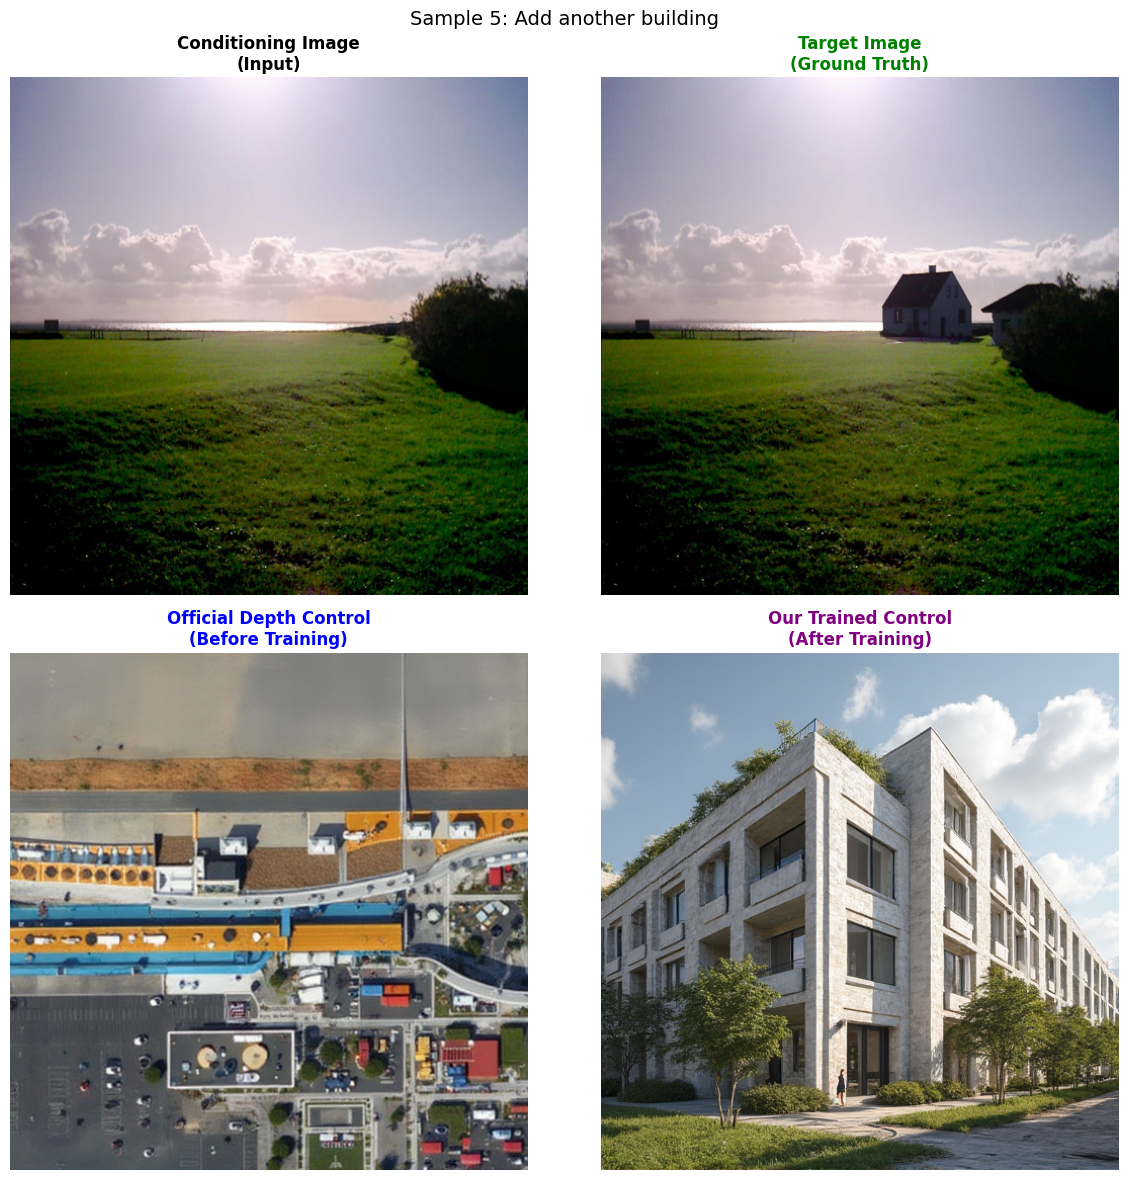

💾 Comparison saved: comparison_5.png

📊 Analysis:
  🔵 Official: Depth-based structure control
  🟢 Target: OmniEdit ground truth editing
  🟣 Trained: Our OmniEdit-trained control
  🎯 Goal: How close is our trained model to target?


<Figure size 640x480 with 0 Axes>

In [2]:
run_trained_control_inference(5)   # Save trained results  
compare_saved_results(5)     

In [4]:
# Set up environment variables for Flux Control training
os.environ["MODEL_NAME"] = "black-forest-labs/FLUX.1-dev"
os.environ["TRAIN_DIR"] = "training_data"
os.environ["OUTPUT_DIR"] = "flux-lora-image-editing_2"

# Training parameters for image-to-image editing
training_config = {
    "pretrained_model_name_or_path": "black-forest-labs/FLUX.1-dev",
    "train_data_dir": "training_data",
    "output_dir": "flux-lora-image-editing", 
    "mixed_precision": "bf16",
    "resolution": 512,  # Start with lower resolution
    "train_batch_size": 2,
    "gradient_accumulation_steps": 4,
    "learning_rate": 1e-5,
    "lr_scheduler": "constant", 
    "lr_warmup_steps": 0,
    "max_train_steps": 750,
    "rank": 32,  # LoRA rank
    "seed": 42,
    "checkpointing_steps" : 150,
    # "validation_prompt": "edit this image to make it more vibrant",
    # "validation_epochs": 50,
    "gradient_checkpointing": True,
    "enable_xformers_memory_efficient_attention": True,
    "conditioning_dropout_prob": 0.1,  # For image editing
}

print("Configuration set for image-to-image editing with Flux Control")

Configuration set for image-to-image editing with Flux Control


In [5]:
# Configure accelerate for single GPU training
!accelerate config default

Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


In [6]:
# # Build training command for Flux Control LoRA (image-to-image editing)
# cmd_parts = [
#     "accelerate launch train_control_lora_flux.py",
#     f"--pretrained_model_name_or_path={training_config['pretrained_model_name_or_path']}",
#     f"--train_data_dir={training_config['train_data_dir']}",
#     f"--output_dir={training_config['output_dir']}",
#     f"--mixed_precision={training_config['mixed_precision']}",
#     f"--resolution={training_config['resolution']}",
#     f"--train_batch_size={training_config['train_batch_size']}",
#     f"--gradient_accumulation_steps={training_config['gradient_accumulation_steps']}",
#     f"--learning_rate={training_config['learning_rate']}",
#     f"--lr_scheduler={training_config['lr_scheduler']}",
#     f"--lr_warmup_steps={training_config['lr_warmup_steps']}",
#     f"--max_train_steps={training_config['max_train_steps']}",
#     f"--rank={training_config['rank']}",
#     f"--seed={training_config['seed']}",
#     f"--conditioning_dropout_prob={training_config['conditioning_dropout_prob']}",
#     "--gradient_checkpointing",
#     "--enable_xformers_memory_efficient_attention"
# ]

# training_command = " \\\n  ".join(cmd_parts)
# print("Training command for image-to-image editing with LoRA:")
# print(training_command)
# print("\n" + "="*50)

# # Execute training
# !{training_command}

In [ ]:
import diffusers
import os

# Check diffusers version and choose appropriate training script
version = diffusers.__version__
use_flux_control = ("dev" in version or version >= "0.34.0") and os.path.exists("train_control_lora_flux.py")

if use_flux_control:
    print("Using Flux Control LoRA training (GPU-only mode)")
    
    # Create a JSONL file for the Flux Control script
    import json
    import glob
    
    print("Creating JSONL training file...")
    
    # Get all image files
    image_files = sorted(glob.glob("training_data/images/*.jpg"))
    conditioning_files = sorted(glob.glob("training_data/conditioning_images/*.jpg"))
    caption_files = sorted(glob.glob("training_data/images/*.txt"))
    
    # Create JSONL entries
    jsonl_data = []
    for i, (img_file, cond_file, cap_file) in enumerate(zip(image_files, conditioning_files, caption_files)):
        if os.path.exists(cap_file):
            with open(cap_file, 'r') as f:
                caption = f.read().strip()
            
            jsonl_data.append({
                "image": img_file,
                "conditioning_image": cond_file,
                "text": caption
            })
    
    # Save JSONL file
    with open("training_data.jsonl", "w") as f:
        for item in jsonl_data:
            f.write(json.dumps(item) + "\n")
    
    print(f"Created JSONL with {len(jsonl_data)} entries")
    
    # Build training command for Flux Control LoRA - GPU optimized
    cmd_parts = [
        "accelerate launch train_control_lora_flux.py",
        f"--pretrained_model_name_or_path={training_config['pretrained_model_name_or_path']}",
        f"--jsonl_for_train=training_data.jsonl",
        f"--output_dir={training_config['output_dir']}",
        f"--mixed_precision={training_config['mixed_precision']}",
        f"--resolution={training_config['resolution']}",
        f"--train_batch_size={training_config['train_batch_size']}",
        f"--gradient_accumulation_steps={training_config['gradient_accumulation_steps']}",
        f"--learning_rate={training_config['learning_rate']}",
        f"--lr_scheduler={training_config['lr_scheduler']}",
        f"--lr_warmup_steps={training_config['lr_warmup_steps']}",
        f"--max_train_steps={training_config['max_train_steps']}",
        f"--rank={training_config['rank']}",
        f"--seed={training_config['seed']}",
        "--gradient_checkpointing",
        "--image_column=image",
        "--conditioning_image_column=conditioning_image", 
        "--caption_column=text",
        "--use_8bit_adam",  # Memory efficient optimizer
        "--dataloader_num_workers=0",  # Reduce CPU load
        "--allow_tf32"  # Faster training on Ampere GPUs
        # Removed --offload to keep everything on GPU
    ]
else:
    print("Using Dreambooth LoRA training (fallback option)")
    
    # Build training command for Dreambooth LoRA with memory optimization
    cmd_parts = [
        "accelerate launch train_dreambooth_lora_flux.py",
        f"--pretrained_model_name_or_path={training_config['pretrained_model_name_or_path']}",
        f"--instance_data_dir=training_data/images",
        f"--output_dir={training_config['output_dir']}",
        f"--mixed_precision={training_config['mixed_precision']}",
        f"--instance_prompt='edit this image'",
        f"--resolution={training_config['resolution']}",
        f"--train_batch_size={training_config['train_batch_size']}",
        f"--gradient_accumulation_steps={training_config['gradient_accumulation_steps']}",
        f"--learning_rate={training_config['learning_rate']}",
        f"--lr_scheduler={training_config['lr_scheduler']}",
        f"--lr_warmup_steps={training_config['lr_warmup_steps']}",
        f"--max_train_steps={training_config['max_train_steps']}",
        f"--rank={training_config['rank']}",
        f"--seed={training_config['seed']}",
        "--gradient_checkpointing",
        "--use_8bit_adam",
        "--allow_tf32"
    ]

training_command = " \\\n  ".join(cmd_parts)
print(f"\nTraining command (GPU-only mode):")
print(training_command)
print("\n" + "="*50)

# Set GPU memory optimization environment variables
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

print("🚀 Starting GPU-only training...")
print("GPU optimizations enabled:")
print("  ✅ 8-bit Adam optimizer") 
print("  ✅ Gradient checkpointing")
print("  ✅ TF32 acceleration")
print("  ✅ CUDA memory management")
print("  ❌ CPU offloading disabled (GPU-only)")

# Check GPU memory before training
import torch
if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"  📊 Available GPU memory: {gpu_memory:.1f} GB")
    
    # Clear any existing cache
    torch.cuda.empty_cache()
    print("  🧹 Cleared GPU cache")

# Execute training
!{training_command}

Using Flux Control LoRA training (GPU-only mode)
Creating JSONL training file...
Created JSONL with 1500 entries

Training command (GPU-only mode):
accelerate launch train_control_lora_flux.py \
  --pretrained_model_name_or_path=black-forest-labs/FLUX.1-dev \
  --jsonl_for_train=training_data.jsonl \
  --output_dir=flux-lora-image-editing \
  --mixed_precision=bf16 \
  --resolution=512 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=4 \
  --learning_rate=1e-05 \
  --lr_scheduler=constant \
  --lr_warmup_steps=0 \
  --max_train_steps=750 \
  --rank=32 \
  --seed=42 \
  --gradient_checkpointing \
  --image_column=image \
  --conditioning_image_column=conditioning_image \
  --caption_column=text \
  --use_8bit_adam \
  --dataloader_num_workers=0 \
  --allow_tf32

🚀 Starting GPU-only training...
GPU optimizations enabled:
  ✅ 8-bit Adam optimizer
  ✅ Gradient checkpointing
  ✅ TF32 acceleration
  ✅ CUDA memory management
  ❌ CPU offloading disabled (GPU-only)
  📊 Available GPU m

In [ ]:
# compare_with_our_trained_model()

In [ ]:
import torch
from diffusers import FluxPipeline, FluxControlPipeline
from diffusers.utils import load_image
import os

# Check which training approach was used based on available outputs
flux_control_output = os.path.exists("flux-lora-image-editing") and any("control" in f for f in os.listdir("flux-lora-image-editing") if f.endswith('.safetensors'))
dreambooth_output = os.path.exists("flux-lora-image-editing") and any("pytorch_lora_weights" in f for f in os.listdir("flux-lora-image-editing") if f.endswith('.safetensors'))

print(f"Flux Control output detected: {flux_control_output}")
print(f"Dreambooth output detected: {dreambooth_output}")

if flux_control_output:
    print("Loading Flux Control pipeline for image editing...")
    # Load the base model for image editing
    pipe = FluxControlPipeline.from_pretrained(
        "black-forest-labs/FLUX.1-dev", 
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    # Load the trained LoRA weights
    pipe.load_lora_weights("flux-lora-image-editing")
    
    # Load a test image for editing
    test_image = load_image("training_data/conditioning_images/image_0000.jpg")
    print(f"Test image size: {test_image.size}")
    
    # Test image editing
    prompt = "make this image more vibrant and colorful"
    edited_image = pipe(
        control_image=test_image,
        prompt=prompt, 
        num_inference_steps=20,
        guidance_scale=7.5,
        width=512,
        height=512
    ).images[0]
    
    # Display results
    from IPython.display import display
    print("Original image:")
    display(test_image.resize((256, 256)))
    print("Edited image:")
    display(edited_image.resize((256, 256)))
    
else:
    print("Loading regular Flux pipeline with LoRA...")
    # Load the base model
    pipe = FluxPipeline.from_pretrained(
        "black-forest-labs/FLUX.1-dev", 
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    # Load the trained LoRA weights
    pipe.load_lora_weights("flux-lora-image-editing")
    
    # Test generation with editing prompt
    prompt = "edit this image to make it more vibrant and colorful"
    edited_image = pipe(
        prompt=prompt, 
        num_inference_steps=20,
        guidance_scale=7.5,
        width=512,
        height=512
    ).images[0]
    
    # Display result
    from IPython.display import display
    print("Generated edited image:")
    display(edited_image.resize((256, 256)))

# Save results
edited_image.save("test_edit_output.png")
print("Edited image saved as test_edit_output.png")